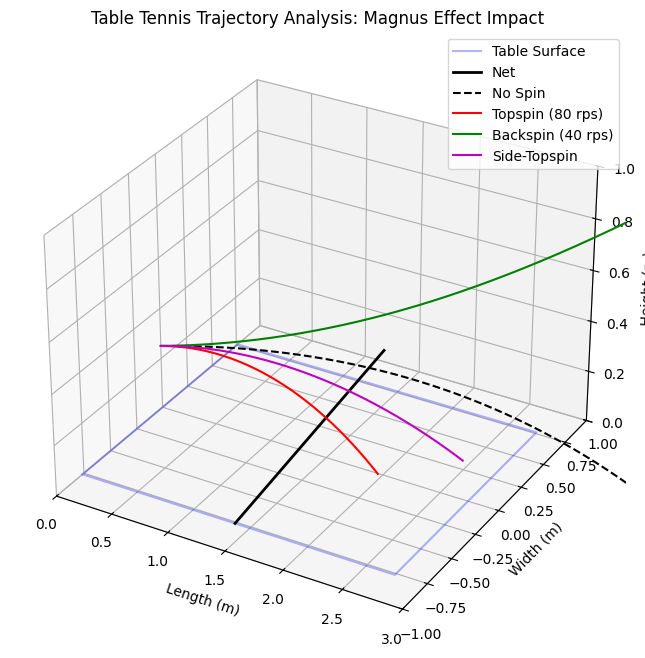

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #to rotate the graph

#constants
M = 0.0027        # mass of the ball
R = 0.02          # radius
G = 9.81          # gravity
RHO = 1.225       # air density
A = np.pi * R**2  # cross section area
CD = 0.47         # drag coefficient
K_MAGNUS = 0.5 * RHO * A * R # Magnus lift coefficient factor

# Euler method
def get_acceleration(v, omega):
    v_mag = np.linalg.norm(v) #vector of velocity magnitude


    f_grav = np.array([0, 0, -M * G])


    f_drag = -0.5 * RHO * v_mag**2 * CD * A * (v / v_mag) #drag force using velocitty unit vector

    #force is perpendicular to both spin axis and velocity so it uses cross product
    f_magnus = K_MAGNUS * np.cross(omega, v)

    return (f_grav + f_drag + f_magnus) / M #returns acceleration

def simulate(v0, spin_rps, dt=0.001):
    pos = np.array([0.0, 0.0, 0.25]) # start 25cm high at end of table
    v = np.array(v0, dtype=float)
    omega = 2 * np.pi * np.array(spin_rps, dtype=float) # convert rps to rad/s

    path = [pos.copy()]
    for _ in range(2000): # 2 seconds of flight
        a = get_acceleration(v, omega)
        v += a * dt      # euler step to update velocity
        pos += v * dt    # euler step to update position
        path.append(pos.copy())
        if pos[2] <= 0: break # stops when it hits table
    return np.array(path)


def plot_analysis():
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # draw table (2.74m x 1.525m)
    tx = [0, 2.74, 2.74, 0, 0]; ty = [-0.7625, -0.7625, 0.7625, 0.7625, -0.7625]
    ax.plot(tx, ty, [0]*5, 'b-', alpha=0.3, label="Table Surface")
    ax.plot([1.37, 1.37], [-0.7625, 0.7625], [0, 0.1525], 'k-', linewidth=2, label="Net")

    # no spin
    p_none = simulate([15, 0, 2], [0, 0, 0])
    ax.plot(p_none[:,0], p_none[:,1], p_none[:,2], 'k--', label="No Spin")

    # heavy topspin (Dives down)
    p_top = simulate([15, 0, 2], [0, 80, 0])
    ax.plot(p_top[:,0], p_top[:,1], p_top[:,2], 'r-', label="Topspin (80 rps)")

    # backspin (floats/lifts)
    p_back = simulate([15, 0, 2], [0, -40, 0])
    ax.plot(p_back[:,0], p_back[:,1], p_back[:,2], 'g-', label="Backspin (40 rps)")

    # sidespin (Curves sideways)
    p_side = simulate([15, 0, 2], [0, 50, 40])
    ax.plot(p_side[:,0], p_side[:,1], p_side[:,2], 'm-', label="Side-Topspin")

    ax.set_xlim(0, 3); ax.set_ylim(-1, 1); ax.set_zlim(0, 1)
    ax.set_xlabel("Length (m)"); ax.set_ylabel("Width (m)"); ax.set_zlabel("Height (m)")
    ax.set_title("Table Tennis Trajectory Analysis: Magnus Effect Impact")
    ax.legend(); plt.show()

plot_analysis()

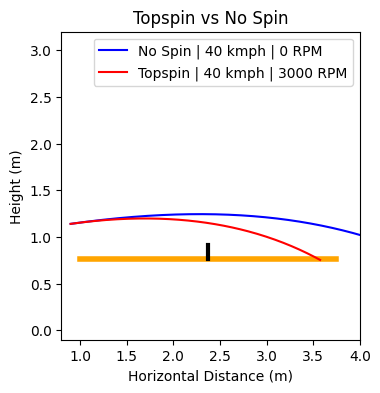

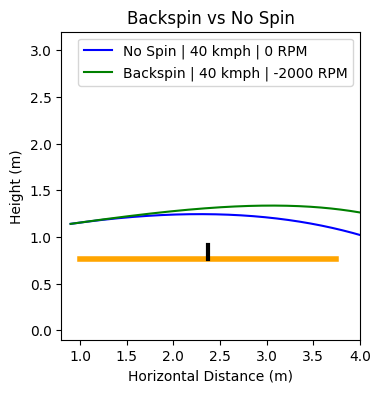

Topspin Descent Angle: -28.708592227916025
No Spin Descent Angle: -24.73030922019645
Angle Difference: -3.9782830077195754

Backspin Descent Angle: -31.83756435222842
No Spin Descent Angle: -24.73030922019645
Angle Difference: -7.10725513203197

Greater descent angle magnitude -> steeper landing -> larger vertical drop -> greater margin of error -> safer shot.


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math

# constants

R = 20e-3
m = 2.7e-3
rho = 1.23
g = 9.8

L = 2.74
L0 = 1
H = 0.76
NH = 0.1525
points = 1000   #number of steps used



def magnus2(y,t,w):  #differential equation

    wz = -(w*(2*math.pi/60))  #convert to radian per sec
    v = math.sqrt(y[2]**2 + y[3]**2)  # total speed
    vspin = abs(wz*R)  # serface velocity deu to rotation

    CL = 0  #lift const
    CD = 0.55  #drag const
    mag = 0  # magnus acceleration

    if w != 0:  #if spin isn't zero
        CL = 1/(2+(v/vspin))
        temp1 = v/vspin
        temp = 22.2 + 4.2*(temp1**2.5)
        CD = 0.55 + 1/(temp**0.4)
        mag = wz/abs(wz)*(math.pi*rho*R*R*CL*v)/(2*m)

    drag = (math.pi*rho*R*R*CD*v)/(2*m)  #acceleration drag

    yd = [0,0,0,0]
    yd[0] = y[2]   #dx/dt =vx
    yd[1] = y[3]   #dy/dt = vy
    yd[2] = -y[3]*mag - y[2]*drag  #horizontal acc
    yd[3] = y[2]*mag - g - y[3]*drag  # vertical acc

    return yd



def simulate(v_kmph, angle_deg, spin_rpm): # angle_deg is launch angle

    angle = math.radians(angle_deg)
    v0 = v_kmph * 1000 / 3600

    vx0 = v0 * math.cos(angle)
    vy0 = v0 * math.sin(angle)

    x0 = L0 - 0.1  # initial postion above the table
    y0 = H + 2.5*NH

    yp0 = [x0,y0,vx0,vy0]
    t = np.linspace(0,2,points)

    yp = odeint(magnus2,yp0,t,args=(spin_rpm,))

    # stop the trajectory
    cnt = points-1
    for i in range(points):
        if yp[i,1] < H: # if ball falls below the table it will stop
            cnt = i
            break

    x = yp[:cnt+1,0]
    y = yp[:cnt+1,1]

    landing_vx = yp[cnt,2]
    landing_vy = yp[cnt,3]
    descent_angle = math.degrees(math.atan2(landing_vy, landing_vx))

    return x,y,descent_angle



def draw_table():
    xtab = np.linspace(L0,L0+L,points)
    ytab = np.ones(points)*H
    plt.plot(xtab,ytab,color='orange',linewidth=4)
    plt.plot([L0+L/2,L0+L/2],[H,H+NH],color='black',linewidth=3)



speed = 40
angle = 8

# topspin
plt.figure(figsize=(8,4))
draw_table()

x_ns,y_ns,ang_ns = simulate(speed,angle,0)
plt.plot(x_ns,y_ns,color='blue',
         label=f"No Spin | {speed} kmph | 0 RPM")

x_ts,y_ts,ang_ts = simulate(speed,angle,3000)
plt.plot(x_ts,y_ts,color='red',
         label=f"Topspin | {speed} kmph | 3000 RPM")

plt.xlim(L0-0.2,4)
yran = 4-(L0-0.1)+0.2
plt.ylim(-0.1,-0.1+yran)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Topspin vs No Spin")
plt.xlabel("Horizontal Distance (m)")
plt.ylabel("Height (m)")
plt.legend()
plt.show()

# backspin
plt.figure(figsize=(8,4))
draw_table()

x_ns2,y_ns2,ang_ns2 = simulate(speed,angle,0)
plt.plot(x_ns2,y_ns2,color='blue',
         label=f"No Spin | {speed} kmph | 0 RPM")

x_bs,y_bs,ang_bs = simulate(speed,angle,-2000)
plt.plot(x_bs,y_bs,color='green',
         label=f"Backspin | {speed} kmph | -2000 RPM")

plt.xlim(L0-0.2,4)
plt.ylim(-0.1,-0.1+yran)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Backspin vs No Spin")
plt.xlabel("Horizontal Distance (m)")
plt.ylabel("Height (m)")
plt.legend()
plt.show()

# angle difference
print("Topspin Descent Angle:", ang_ts)
print("No Spin Descent Angle:", ang_ns)
print("Angle Difference:", ang_ts - ang_ns)
print()
print("Backspin Descent Angle:", ang_bs)
print("No Spin Descent Angle:", ang_ns2)
print("Angle Difference:", ang_bs - ang_ns2)

print("\nGreater descent angle magnitude -> steeper landing -> larger vertical drop -> greater margin of error -> safer shot.")


Speed: 60 kmph
Spin: 3000 RPM

⚠ No valid solution found.
Reason Analysis:
Net Fail: 385
Short Fail: 0
Long Fail: 515
Physics: Speed and spin combination not playable.


/tmp/ipython-input-864336809.py:193: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


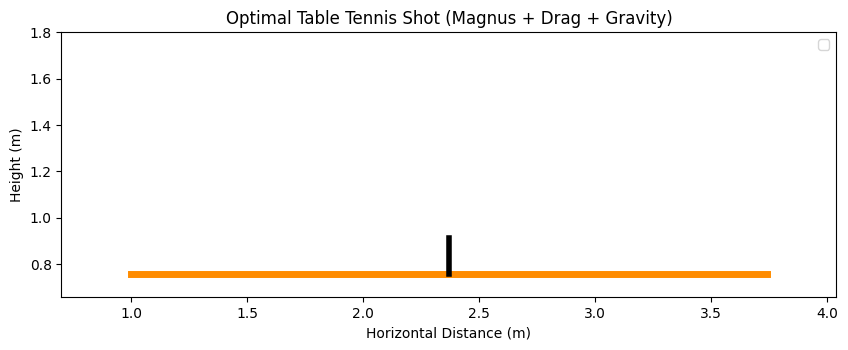

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import math

# constants

R = 20e-3
m = 2.7e-3
rho = 1.23
g = 9.8

L = 2.74
L0 = 1.0
H = 0.76
NH = 0.1525

net_x = L0 + L/2
NET_CLEARANCE = 0.02  # safety clearance above net is 2cm



def magnus_model(t, y, spin_rpm):

    w = -(spin_rpm * 2*math.pi/60) #spin to angular velocity

    vx, vy = y[2], y[3]
    v = np.sqrt(vx**2 + vy**2) #velocity

    if v == 0: # edge case if there is no spin only g will act
        return [vx, vy, 0, -g]

    vspin = abs(w*R) # surface velocity
    CD = 0.55
    CL = 0
    mag = 0

    if spin_rpm != 0: # preent division with zero. no spin no magnus effect required
        CL = 1/(2 + (v/vspin))  # higher spin greter the lift
        temp = 22.2 + 4.2*(v/vspin)**2.5
        CD = 0.55 + 1/(temp**0.4)
        mag = np.sign(w)*(np.pi*rho*R**2*CL*v)/(2*m) #magnus acceleration

    drag = (np.pi*rho*R**2*CD*v)/(2*m)

    ax = -vy*mag - vx*drag
    ay = vx*mag - g - vy*drag

    return [vx, vy, ax, ay]


def simulate(speed_kmph, angle_deg, spin_rpm):

    #components
    v0 = speed_kmph * 1000/3600
    theta = math.radians(angle_deg)

    vx0 = v0 * math.cos(theta)
    vy0 = v0 * math.sin(theta)

    #starting positions
    x0 = L0 - 0.3
    y0 = H

    sol = solve_ivp(
        magnus_model,
        [0,3],
        [x0,y0,vx0,vy0],
        args=(spin_rpm,),
        max_step=0.003
    ) # repeats computation of acceleration, updates velocity and position for 3 sec

    # extract trajectory
    x = sol.y[0]
    y = sol.y[1]

    landing_x = None
    landing_y = None

    for i in range(len(y)):
        if y[i] < H:  #stops when ball hits the table
            landing_x = x[i]
            landing_y = y[i]
            break

    return x, y, landing_x



def analyze_shot(speed, spin):

    valid_angles = []
    net_fail = 0
    long_fail = 0
    short_fail = 0

    for angle in np.linspace(1,25,900): # tries 900 angles between 1 to 25

        x, y, landing_x = simulate(speed, angle, spin)

        if landing_x is None:
            continue

        y_net = np.interp(net_x, x, y)

        if y_net < H + NH + NET_CLEARANCE:  # cehcks for net clearance
            net_fail += 1
            continue

        if landing_x < L0:  # checks if ball lands on the table
            short_fail += 1
            continue

        if landing_x > L0 + L:
            long_fail += 1
            continue

        valid_angles.append(angle)

    if len(valid_angles) == 0:
        print("\n⚠ No valid solution found.")
        print("Reason Analysis:")
        print("Net Fail:", net_fail)
        print("Short Fail:", short_fail)
        print("Long Fail:", long_fail)
        print("Physics: Speed and spin combination not playable.")
        return None

    return min(valid_angles)



speed = 60
spin = 3000

print("Speed:", speed, "kmph")
print("Spin:", spin, "RPM")

angle = analyze_shot(speed, spin)



plt.figure(figsize=(10,4))

# table
xtab = np.linspace(L0, L0+L, 500)
plt.plot(xtab, np.ones(500)*H, color="darkorange", linewidth=5)

# net
plt.plot([net_x, net_x], [H, H+NH], color="black", linewidth=4)

if angle is not None:

    x, y, landing_x = simulate(speed, angle, spin)

    # plot trajectory
    color = "red" if spin > 0 else "green" if spin < 0 else "blue"
    plt.plot(x, y, color=color, linewidth=2,
             label=f"Spin {spin} RPM | Angle {round(angle,2)}°")

    # mark the landing
    plt.scatter(landing_x, H, color="black", zorder=5)
    plt.text(landing_x, H+0.03, "Landing", ha='center')

    # net clearance visualization
    y_net = np.interp(net_x, x, y)
    plt.scatter(net_x, y_net, color="purple")
    plt.text(net_x, y_net+0.03, "Net Clearance", ha='center')

    descent_angle = math.degrees(math.atan2(y[-1]-y[-5], x[-1]-x[-5]))
    print("\nOptimal Angle:", round(angle,2))
    print("Descent Angle:", round(descent_angle,2))

    print("\nMargin of Error Insight:")
    if spin > 0:
        print("Topspin pulls ball down.")
        print("Allows lower launch angle.")
        print("Flatter but still safe = larger margin.")
    elif spin < 0:
        print("Backspin creates lift.")
        print("Requires higher launch angle.")
        print("Floats longer = smaller safety window.")
    else:
        print("No spin requires precise angle.")
        print("Small errors cause long/short misses.")

plt.title("Optimal Table Tennis Shot (Magnus + Drag + Gravity)")
plt.xlabel("Horizontal Distance (m)")
plt.ylabel("Height (m)")
plt.xlim(L0-0.3, L0+L+0.3)
plt.ylim(H-0.1, 1.8)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')